In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime
import pickle
import gc

In [2]:
n_fold = 10

In [3]:
models_dir = 'models/'

In [4]:
names = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

In [5]:
lags = [10, 20, 50]

In [6]:
individual_models = [[[] for split in range(n_fold)] for name in names]

for n in range(len(names)):
    for split in range(n_fold):
        individual_models[n][split] = pickle.load(open(f'{models_dir}/trained_model_id_{names[n]}_fold{str(split)}.pkl', 'rb'))

In [7]:
models = [[[] for split in range(n_fold)] for name in names]

for n in range(len(names)):
    for split in range(n_fold):
        models[n][split] = pickle.load(open(f'{models_dir}/trained_fullmetal_model_id_{names[n]}_fold{str(split)}.pkl', 'rb'))

In [8]:
len(individual_models),len(individual_models[0]), len(models),len(models[0])

(5, 10, 5, 10)

In [9]:
gc.collect()

0

In [10]:
TRAIN_CSV = 'train_metals_features.csv'

In [11]:
df_silver = pd.read_csv('df_silver.csv', index_col=0).reset_index(drop=True)
df_gold = pd.read_csv('df_gold.csv', index_col=0).reset_index(drop=True)
df_copper = pd.read_csv('df_copper.csv', index_col=0).reset_index(drop=True)
df_palladium = pd.read_csv('df_palladium.csv', index_col=0).reset_index(drop=True)
df_platinum = pd.read_csv('df_platinum.csv',  index_col=0).reset_index(drop=True)

In [12]:
df_silver['Date'] = pd.to_datetime(df_silver['Date'])
df_gold['Date'] = pd.to_datetime(df_gold['Date'])
df_copper['Date'] = pd.to_datetime(df_copper['Date'])
df_palladium['Date'] = pd.to_datetime(df_palladium['Date'])
df_platinum['Date'] = pd.to_datetime(df_platinum['Date'])

In [13]:
df_silver.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2478 entries, 0 to 2477
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Price_Lag_10                          2478 non-null   float64       
 1   log_close/mean_10                     2478 non-null   float64       
 2   log_return_10                         2478 non-null   float64       
 3   Price_Lag_20                          2478 non-null   float64       
 4   log_close/mean_20                     2478 non-null   float64       
 5   log_return_20                         2478 non-null   float64       
 6   Price_Lag_50                          2478 non-null   float64       
 7   log_close/mean_50                     2478 non-null   float64       
 8   log_return_50                         2478 non-null   float64       
 9   mean_close/mean_10                    2478 non-null   float64       
 10  

In [14]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [15]:
df_train = pd.read_csv(TRAIN_CSV)

In [16]:
df_train.drop(columns='Unnamed: 0', inplace=True)

In [17]:
#df_train = reduce_mem_usage(df_train)
train_merged = df_train.copy()

not_use_features_train = ['Date']

for name in names:
    not_use_features_train.append(f'Price_{name}')

features = train_merged.drop(columns=not_use_features_train).columns.to_list()
print(len(features), features)

108 ['Price_Lag_10_Silver', 'log_close/mean_10_Silver', 'log_return_10_Silver', 'Price_Lag_20_Silver', 'log_close/mean_20_Silver', 'log_return_20_Silver', 'Price_Lag_50_Silver', 'log_close/mean_50_Silver', 'log_return_50_Silver', 'mean_close/mean_10_Silver', 'mean_log_returns_10_Silver', 'log_close/mean_10-mean_close/mean_10_Silver', 'log_return_10-mean_log_returns_10_Silver', 'mean_close/mean_20_Silver', 'mean_log_returns_20_Silver', 'log_close/mean_20-mean_close/mean_20_Silver', 'log_return_20-mean_log_returns_20_Silver', 'mean_close/mean_50_Silver', 'mean_log_returns_50_Silver', 'log_close/mean_50-mean_close/mean_50_Silver', 'log_return_50-mean_log_returns_50_Silver', 'Year', 'Month', 'Week_Number', 'Price_Lag_10_Gold', 'log_close/mean_10_Gold', 'log_return_10_Gold', 'Price_Lag_20_Gold', 'log_close/mean_20_Gold', 'log_return_20_Gold', 'Price_Lag_50_Gold', 'log_close/mean_50_Gold', 'log_return_50_Gold', 'mean_close/mean_10_Gold', 'mean_log_returns_10_Gold', 'log_close/mean_10-mean_cl

In [18]:
train_merged.dtypes.unique()

array([dtype('float64'), dtype('O'), dtype('int64')], dtype=object)

In [19]:
train_merged = reduce_mem_usage(train_merged)

Memory usage of dataframe is 2.16 MB
Memory usage after optimization is: 0.62 MB
Decreased by 71.4%


In [20]:
train_merged['Date']

0       2013-04-09
1       2013-04-10
2       2013-04-11
3       2013-04-12
4       2013-04-15
           ...    
2473    2023-02-21
2474    2023-02-22
2475    2023-02-23
2476    2023-02-24
2477    2023-02-27
Name: Date, Length: 2478, dtype: category
Categories (2478, object): ['2013-04-09', '2013-04-10', '2013-04-11', '2013-04-12', ..., '2023-02-22', '2023-02-23', '2023-02-24', '2023-02-27']

In [21]:
def get_lags(df):
    lags = [10,20,50]
    df_out = pd.DataFrame()

    for col in df.columns:

        for lag in lags:
            df_out[f'{col}_Lag_{lag}'] = df[col].shift(lag)
            df_out[f'log_close/mean_{lag}'] = np.log( np.array(df[col]) /  np.roll(np.append(np.convolve( np.array(df[col]), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
            df_out[f'log_return_{lag}']     = np.log( np.array(df[col]) /  np.roll(np.array(df[col]), lag))

        for lag in lags:
            df_out[f'mean_close/mean_{lag}'] =  np.mean(df_out.iloc[:,df_out.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
            df_out[f'mean_log_returns_{lag}'] = np.mean(df_out.iloc[:,df_out.columns.str.startswith(f'log_return_{lag}')] ,    axis=1)

            df_out[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = np.array( df_out[f'log_close/mean_{lag}']) - np.array( df_out[f'mean_close/mean_{lag}']  )
            df_out[f'log_return_{lag}-mean_log_returns_{lag}']    = np.array( df_out[f'log_return_{lag}'])     - np.array( df_out[f'mean_log_returns_{lag}'] )

    return df_out

def get_date_features(df):
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    df_copy['Year'] = df_copy['Date'].dt.year
    df_copy['Month'] = df_copy['Date'].dt.month
    df_copy['Week_Number'] = df_copy['Date'].dt.isocalendar().week
    return df_copy

def get_features(df, max_date='01/01/2013'):
    #df_feat = df[['Price', 'Change_%', 'MA_for_10_days', 'MA_for_20_days', 'MA_for_50_days']].copy() # 'Open', 'High', 'Low', , 
    #df_feat = pd.concat([df_feat, get_lags(df_feat[['MA_for_10_days', 'MA_for_20_days', 'MA_for_50_days']])], axis=1)
    #df_feat['Upper Shadow'] = upper_shadow(df_feat)
    #df_feat['Lower Shadow'] = lower_shadow(df_feat)
    
    # Time window
    df_range = df[df['Date'] >= max_date]

    # Fatures to lag
    df_feat = get_lags(df_range[['Price']])

    # Date features
    date_df = df_range[['Date']].copy()
    date_df['Date'] = pd.to_datetime(date_df['Date'])
    df_feat = pd.concat([df_feat, get_date_features(date_df), df_range[['Price']]], axis=1)
    df_feat.dropna(inplace=True)
    return df_feat

In [22]:
train_merged['Date'] = pd.to_datetime(train_merged['Date'])

In [23]:
train_merged.iloc[-1]['Date'], train_merged.iloc[-1]['Date'] + pd.DateOffset(days=1)

(Timestamp('2023-02-27 00:00:00'), Timestamp('2023-02-28 00:00:00'))

In [24]:
def getNextDates(df):
    from pandas.tseries.holiday import USFederalHolidayCalendar
    from pandas.tseries.offsets import CustomBusinessDay

    us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

    date_range = pd.date_range(
        df.iloc[-1]['Date'] + pd.DateOffset(days=1), 
        df.iloc[-1]['Date'] + pd.DateOffset(days=30), freq=us_bd)
    date_df = pd.DataFrame({'Date': date_range})
    
    return date_df

- Strategy: 
    the model is trained with lags of 10, 20, and 50 days.
    it's also trained using cv of 10, which means, it uses about 9 years of training, and 1 year of data for testing, because the date range is from 2013 to 2023.
    we have 2 types of models, the ones trained with 5 metals standalone, and for each one we have 10 models, totalling 50 models.
    and also 50 more models trained with the whole dataset, so it can see how the other metals behave, which gives it a more general view over the market.

    1) Load the data and generate a future window of time (in us business days).
    2) Take the last price and use it alongside the next valid day to generate the features for inference.
    3) Use the individual models to predict the new Price given the features generated with the last price.
    4) Do the same with the fullmetal models, but using the individual predictions.
    5) Compare them to see if there's an improvement over the fullmetal models.

In [25]:
"""
train_merged:
    Price, Date, Year, Month, WeekNumber, other features...
"""

def getNewDataPoint(df, prediction):
    next_date = getNextDates(df).loc[0]
    new_df = pd.DataFrame({'Price': prediction, 'Date': next_date})
    return new_df.reset_index(drop=True)

def mergeInfer(df, one_line):
    df = pd.concat([df, one_line], axis=0)
    df = df.iloc[1:]
    return df.reset_index(drop=True)

def getInferenceSubset(df_infer, test_size, prediction = None):
    df_result = pd.DataFrame()
    if prediction:
        # After prediction
        df_result = get_features(mergeInfer(df_infer[['Date', 'Price']], getNewDataPoint(df_infer, prediction)))[-test_size:]
    else:
        # First time
        df_result = get_features(df_infer[['Date', 'Price']])[-test_size:]
    return df_result.drop(columns=['Price', 'Date'])

def updateDFMetals(df_metals, predictions):
    df_hist = [x.copy() for x in df_metals]
    next_date = getNextDates(df_hist[0]).loc[0]
    for i in range(len(df_hist)):
        new_df = pd.DataFrame({"Price": predictions[names[i]], 'Date': next_date})
        df_hist[i] = pd.concat([df_hist[i], new_df], axis=0).reset_index(drop=True)
        df_hist[i].reset_index(drop=True)
    return df_hist

In [26]:
test_size = df_silver.shape[0] // n_fold
test_size

247

In [27]:
df_infer = df_silver.copy()

In [28]:
df_infer[['Date', 'Price']]

,Date,Price
0,2013-04-09,27.686
1,2013-04-10,27.731
2,2013-04-11,26.363
3,2013-04-12,23.375
4,2013-04-15,23.647
...,...,...
2473,2023-02-21,21.677
2474,2023-02-22,21.306
2475,2023-02-23,20.810
2476,2023-02-24,20.723


In [29]:
df_metals = [df_silver, df_gold, df_copper, df_palladium, df_platinum]

In [30]:
df_metals_inference = [getInferenceSubset(x, test_size) for x in df_metals]

In [31]:
df_metals_inference[0].tail()

,Price_Lag_10,log_close/mean_10,log_return_10,Price_Lag_20,log_close/mean_20,log_return_20,Price_Lag_50,log_close/mean_50,log_return_50,mean_close/mean_10,...,mean_log_returns_20,log_close/mean_20-mean_close/mean_20,log_return_20-mean_log_returns_20,mean_close/mean_50,mean_log_returns_50,log_close/mean_50-mean_close/mean_50,log_return_50-mean_log_returns_50,Year,Month,Week_Number
2473,22.177,-0.009901,-0.022804,23.665,-0.041379,-0.087745,23.246,-0.073444,-0.069881,-0.009901,...,-0.087745,0.0,0.0,-0.073444,-0.069881,0.0,0.0,2023,2,8
2474,22.420,-0.022063,-0.050965,23.846,-0.053005,-0.112628,23.717,-0.088638,-0.107203,-0.022063,...,-0.112628,0.0,0.0,-0.088638,-0.107203,0.0,0.0,2023,2,8
2475,22.143,-0.039479,-0.062088,23.937,-0.069577,-0.139992,23.403,-0.109963,-0.117431,-0.039479,...,-0.139992,0.0,0.0,-0.109963,-0.117431,0.0,0.0,2023,2,8
2476,22.075,-0.037404,-0.063202,23.534,-0.067446,-0.127202,23.990,-0.111335,-0.146393,-0.037404,...,-0.127202,0.0,0.0,-0.111335,-0.146393,0.0,0.0,2023,2,8
2477,21.852,-0.025414,-0.045596,23.733,-0.053534,-0.128171,24.136,-0.101067,-0.145009,-0.025414,...,-0.128171,0.0,0.0,-0.101067,-0.145009,0.0,0.0,2023,2,9


In [32]:
def inferenceIndividualModels(df_metals):
    results = {}
    for i, (name, dfm) in enumerate(zip(names, df_metals)):
        try:
            y_pred_list = []
            for split in range(n_fold):
                y_pred_list.append(individual_models[i][split].predict(dfm)[-1])
            y_pred = np.median(y_pred_list)
        except Exception as e:
            print('ERROR', e)
            y_pred = 0
        results[name] = y_pred
    return results

In [33]:
predictions = inferenceIndividualModels(df_metals_inference)
predictions

{'Silver': 20.74240927542947,
 'Gold': 1839.456706867536,
 'Copper': 4.1292261767821525,
 'Palladium': 1471.6675107534238,
 'Platinum': 954.9188772181221}

In [34]:
def runInference(df_metals, future_days):
    #  [Price, Date]
    df_hist = [d.copy() for d in df_metals]
    #  [Year, Month, WeekNumber, Lags...]
    df_hist_inf = [getInferenceSubset(x, test_size) for x in df_hist]

    for i in range(future_days):
        # Predict using the last data
        predictions = inferenceIndividualModels(df_hist_inf)

        # Generate a new datapoint using the predictions & append the new datapoint to the dfs
        df_hist = updateDFMetals(df_hist, predictions)

        # Generate features (lags, dates, etc...)
        df_hist_inf = [getInferenceSubset(x, test_size) for x in df_hist]

    return df_hist

In [51]:
future_days = 30

In [52]:
df_results = runInference(df_metals, future_days)

In [53]:
df_metals[0].shape

(2478, 26)

In [54]:
df_results[0].shape

(2508, 26)

In [55]:
df_metals[0]['Date'].max()

Timestamp('2023-02-27 00:00:00')

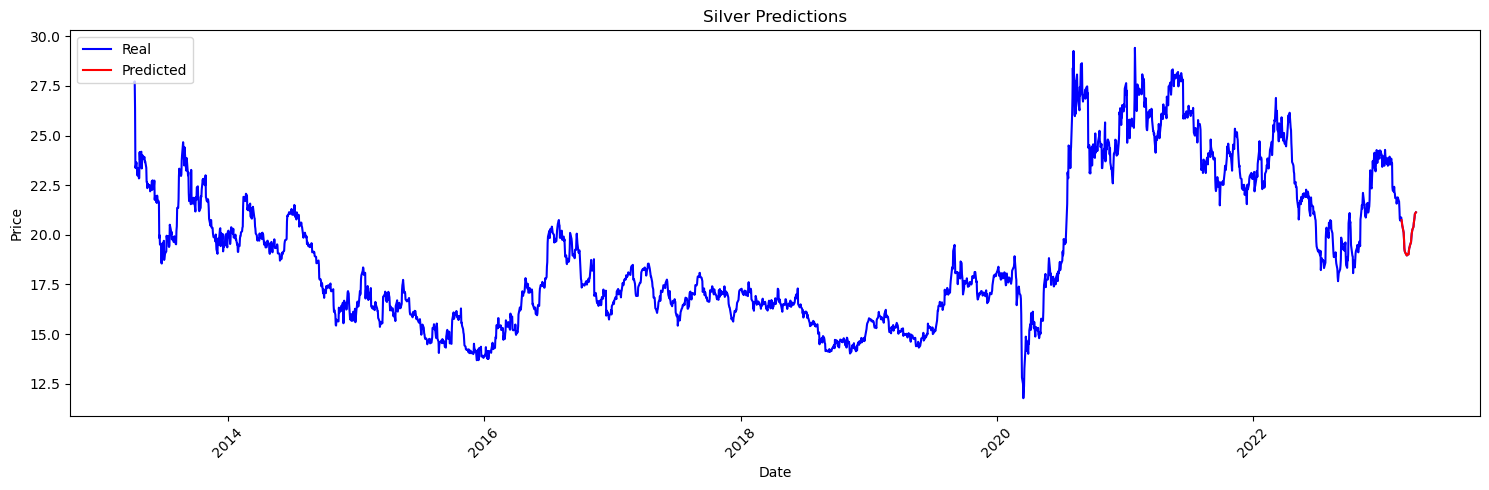

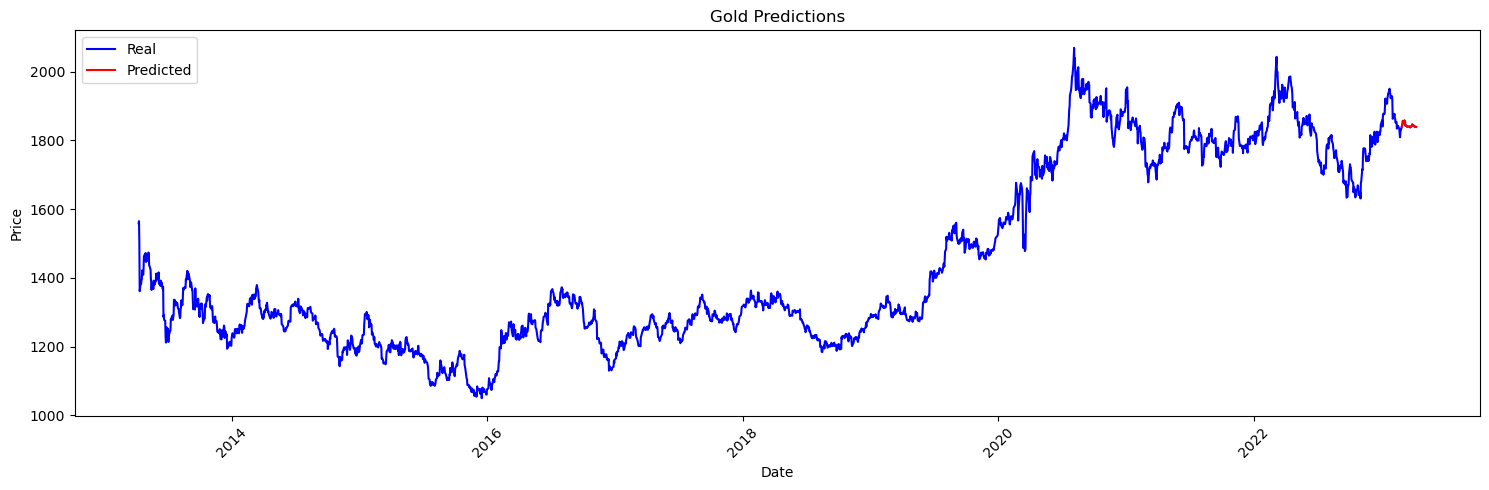

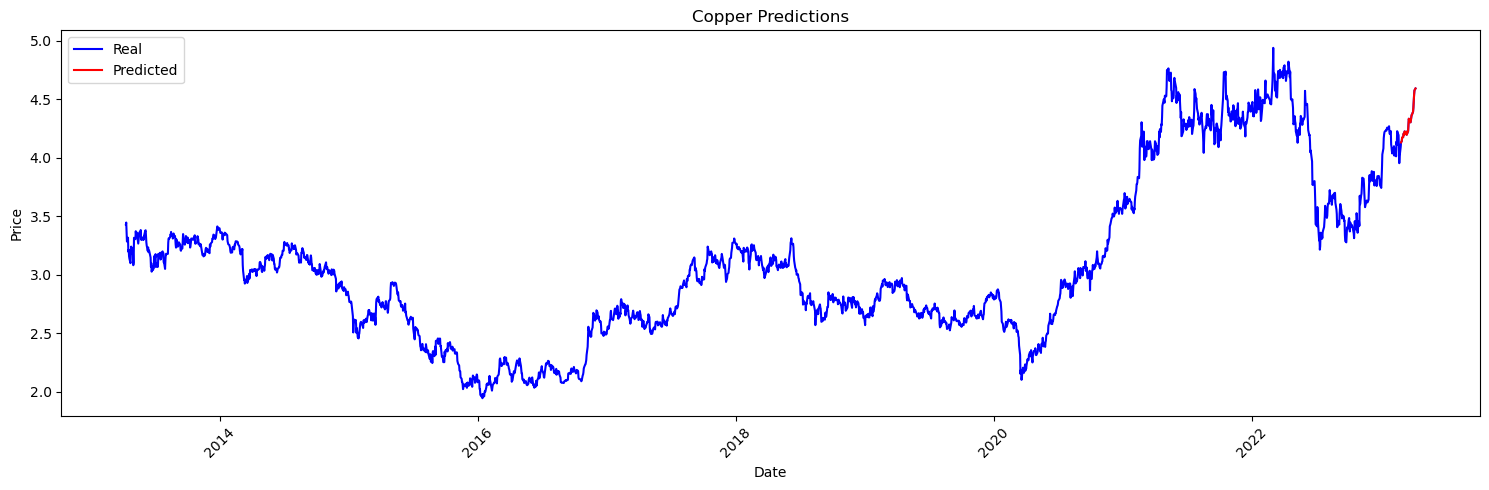

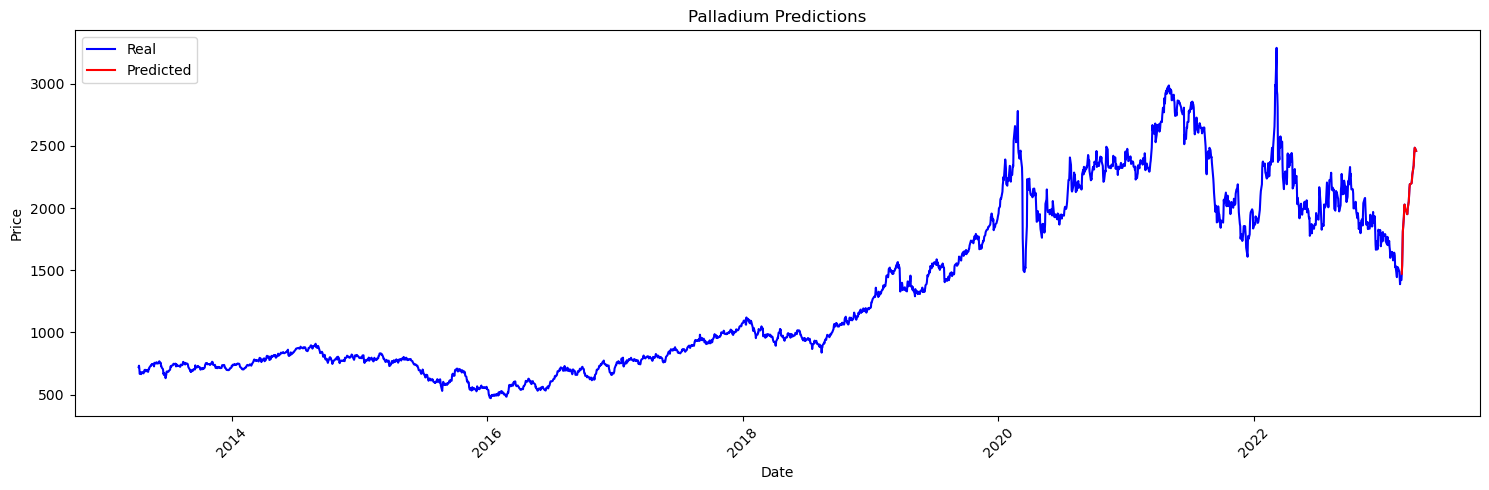

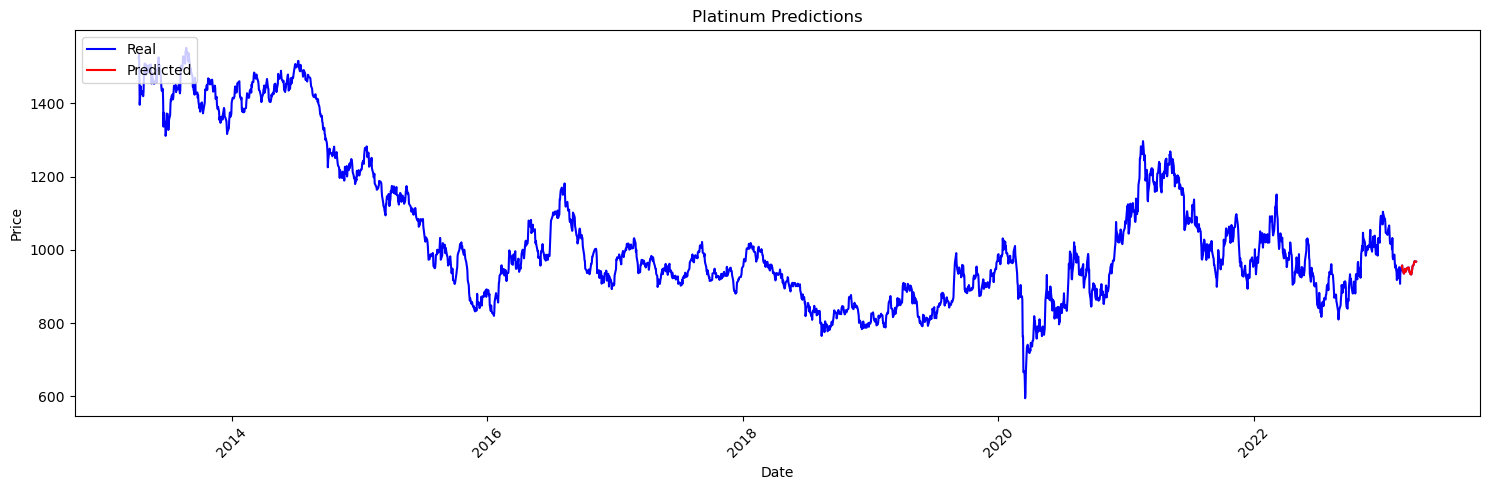

In [56]:
real_color = 'blue'
predicted_color = 'red'

# Create a separate plot for each DataFrame
for idx, (df, name) in enumerate(zip(df_results, names)):
    # Create a new figure for each plot with a size of 15x5
    plt.figure(figsize=(15, 5))
    
    # Plot the real values in blue
    plt.plot(df['Date'], df['Price'], label='Real', color=real_color)
    
    # Plot the last 30 days of data in red for predicted values
    plt.plot(df['Date'][-future_days:], df['Price'][-future_days:], label='Predicted', color=predicted_color)
    
    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{name} Predictions')
    plt.legend(loc='upper left')
    
    # Rotate x-axis labels for better readability if needed
    plt.xticks(rotation=45)
    
    # Show the plot
    plt.tight_layout()
    plt.show()